<a href="https://colab.research.google.com/github/OviRata/PMP-2024/blob/main/Partial/PregatirePartial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pgmpy
import numpy as np

# Step 1: Simulate the game
def simulate_game(num_simulations=10000):
    # Probabilities for J0 and J1
    p_J0 = 0.5  # Fair coin
    p_J1 = 2/3  # Biased coin

    # Results storage
    wins_J0 = 0
    wins_J1 = 0

    for _ in range(num_simulations):
        # Decide who starts
        starter = np.random.choice(["J0", "J1"], p=[0.5, 0.5])

        if starter == "J0":
            # J0's toss
            n_heads_J0 = np.random.binomial(1, p_J0)
            # J1's toss with n_heads_J0 + 1 attempts
            n_heads_J1 = np.random.binomial(n_heads_J0 + 1, p_J1)
            # Determine winner
            if n_heads_J0 >= n_heads_J1:
                wins_J0 += 1
            else:
                wins_J1 += 1
        else:  # starter == "J1"
            # J1's toss
            n_heads_J1 = np.random.binomial(1, p_J1)
            # J0's toss with n_heads_J1 + 1 attempts
            n_heads_J0 = np.random.binomial(n_heads_J1 + 1, p_J0)
            # Determine winner
            if n_heads_J0 >= n_heads_J1:
                wins_J0 += 1
            else:
                wins_J1 += 1

    # Calculate probabilities
    prob_J0 = wins_J0 / num_simulations
    prob_J1 = wins_J1 / num_simulations

    return prob_J0, prob_J1

# Run simulation
prob_J0, prob_J1 = simulate_game()
prob_J0, prob_J1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00


(0.6348, 0.3652)

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Step 2: Define the Bayesian Network
# Create the model structure
model = BayesianNetwork([
    ("Starter", "J0_Heads"),  # Starter influences J0's toss
    ("Starter", "J1_Heads"), # Starter influences J1's toss
    ("J0_Heads", "Winner"),  # J0's toss influences winner
    ("J1_Heads", "Winner")   # J1's toss influences winner
])

# Define CPDs (Conditional Probability Distributions)
# 1. Who starts: equal probability
cpd_starter = TabularCPD(variable="Starter", variable_card=2,
                         values=[[0.5], [0.5]],
                         state_names={"Starter": ["J0", "J1"]})

# 2. J0 toss (fair coin)
cpd_j0_heads = TabularCPD(variable="J0_Heads", variable_card=2,
                          values=[[0.5, 0.5], [0.5, 0.5]],
                          evidence=["Starter"], evidence_card=[2],
                          state_names={"Starter": ["J0", "J1"], "J0_Heads": [0, 1]})

# 3. J1 toss (biased coin)
cpd_j1_heads = TabularCPD(variable="J1_Heads", variable_card=2,
                          values=[[1/3, 1/3], [2/3, 2/3]],
                          evidence=["Starter"], evidence_card=[2],
                          state_names={"Starter": ["J0", "J1"], "J1_Heads": [0, 1]})

# 4. Winner determination
cpd_winner = TabularCPD(variable="Winner", variable_card=2,
                        values=[
                            [1, 1, 0, 0],  # J0 wins if J0_Heads >= J1_Heads
                            [0, 0, 1, 1]   # J1 wins otherwise
                        ],
                        evidence=["J0_Heads", "J1_Heads"], evidence_card=[2, 2],
                        state_names={
                            "J0_Heads": [0, 1],
                            "J1_Heads": [0, 1],
                            "Winner": ["J0", "J1"]
                        })

# Add CPDs to the model
model.add_cpds(cpd_starter, cpd_j0_heads, cpd_j1_heads, cpd_winner)

# Check if the model is valid
model.check_model()


True

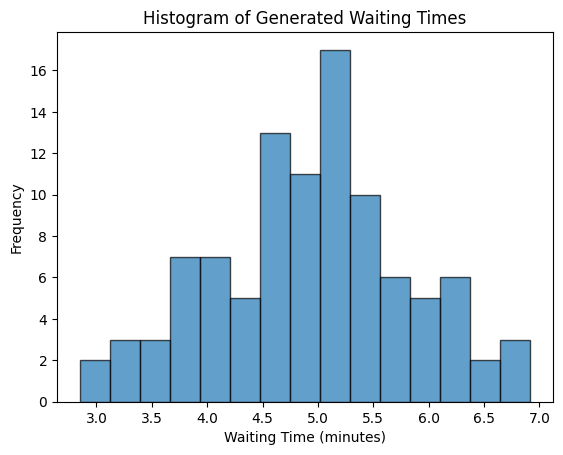

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the normal distribution
mu_true = 5  # True mean (in minutes)
sigma_true = 1  # True standard deviation

# Generate 100 samples
waiting_times = np.random.normal(loc=mu_true, scale=sigma_true, size=100)

# Plot the data
plt.hist(waiting_times, bins=15, edgecolor="k", alpha=0.7)
plt.title("Histogram of Generated Waiting Times")
plt.xlabel("Waiting Time (minutes)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import pymc as pm

# Bayesian model
with pm.Model() as model:
    # Priors for mu and sigma
    mu = pm.Normal("mu", mu=4, sigma=2)  # Prior belief about the mean
    sigma = pm.HalfNormal("sigma", sigma=1)  # Prior belief about std dev

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=waiting_times)

    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)


Output()

Output()

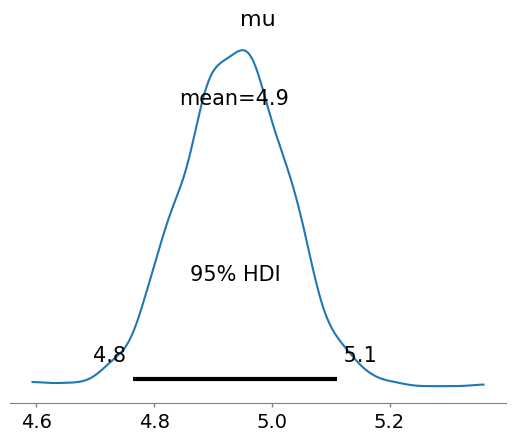

In [ ]:
import arviz as az

# Plot posterior
az.plot_posterior(trace, var_names=["mu"], hdi_prob=0.95)
plt.show()
